 #======================
# 📦 SETUP & INSTALLS
# ======================

In [2]:

!pip install openai-whisper librosa numpy matplotlib seaborn scikit-learn torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 21.0 MB/s

# ======================
# 🧠 LOAD WHISPER MODEL
# ======================

In [4]:


import os
import zipfile
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import whisper
import pandas as pd
import re

# ======================
# 📁 UNZIP AUDIO FILES
# ======================


# Unzip into a working folder
with zipfile.ZipFile("voice_samples.zip", 'r') as zip_ref:
    zip_ref.extractall("voice_samples")


asr_model = whisper.load_model("base")




100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 133MiB/s]


In [12]:
print("📁 Extracted files:")
print(os.listdir("voice_samples"))


📁 Extracted files:
['voice_samples']


# ======================
# 🔧 FEATURE FUNCTIONS
# ======================

In [5]:

def transcribe_with_whisper(audio_file):
    result = asr_model.transcribe(audio_file)
    return result['text']

def calculate_speech_rate(text, duration_sec):
    words = text.split()
    return len(words) / duration_sec if duration_sec > 0 else 0

def count_hesitations(text):
    hesitations = re.findall(r"\\b(uh|um|er|ah|hmm)\\b", text.lower())
    return len(hesitations)

def estimate_pauses(audio_file):
    y, sr = librosa.load(audio_file)
    intervals = librosa.effects.split(y, top_db=30)
    silence_durations = []
    for i in range(1, len(intervals)):
        previous_end = intervals[i-1][1]
        current_start = intervals[i][0]
        silence = (current_start - previous_end) / sr
        if silence > 0.2:
            silence_durations.append(silence)
    return len(silence_durations)

def extract_pitch_features(audio_file):
    y, sr = librosa.load(audio_file)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[magnitudes > np.median(magnitudes)]
    if len(pitch_values) == 0:
        return 0, 0
    return np.mean(pitch_values), np.std(pitch_values)

def extract_features(audio_path):
    duration = librosa.get_duration(filename=audio_path)
    transcript = transcribe_with_whisper(audio_path)

    return {
        "filename": os.path.basename(audio_path),
        "duration_sec": duration,
        "transcript": transcript,
        "speech_rate": calculate_speech_rate(transcript, duration),
        "num_hesitations": count_hesitations(transcript),
        "num_pauses": estimate_pauses(audio_path),
        "pitch_mean": extract_pitch_features(audio_path)[0],
        "pitch_std": extract_pitch_features(audio_path)[1]
    }


# ======================
# 🚀 PROCESS AUDIO FILES
# ======================

In [18]:
audio_directory = "/content/voice_samples/voice_samples"
feature_data = []

for file in os.listdir(audio_directory):
    if file.endswith(".wav") or file.endswith(".mp3"):
        path = os.path.join(audio_directory, file)
        print(f"🟡 Trying to process: {path}")

        try:
            duration = librosa.get_duration(filename=path)
            if duration < 1.0:
                print(f"⚠️ Skipping {file} (too short)")
                continue

            features = extract_features(path)
            feature_data.append(features)
            print(f"✅ Processed: {file}")

        except Exception as e:
            print(f"❌ Failed to process {file}: {e}")


# 🔍 DEBUGGING: Print dataframe to verify
df = pd.DataFrame(feature_data)

🟡 Trying to process: /content/voice_samples/voice_samples/sampl1.wav


<ipython-input-18-ce708c006992>:13: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=path)
<ipython-input-5-3e502baf80a9>:37: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audio_path)
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Processed: sampl1.wav
🟡 Trying to process: /content/voice_samples/voice_samples/sample2.wav


<ipython-input-18-ce708c006992>:13: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=path)
<ipython-input-5-3e502baf80a9>:37: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audio_path)
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Processed: sample2.wav
🟡 Trying to process: /content/voice_samples/voice_samples/sample3.wav


<ipython-input-18-ce708c006992>:13: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=path)
<ipython-input-5-3e502baf80a9>:37: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audio_path)
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Processed: sample3.wav
🔎 Columns in DataFrame: ['filename', 'duration_sec', 'transcript', 'speech_rate', 'num_hesitations', 'num_pauses', 'pitch_mean', 'pitch_std']
📄 Preview of extracted features:
      filename  duration_sec  \
0   sampl1.wav         5.220   
1  sample2.wav         3.420   
2  sample3.wav         4.608   

                                          transcript  speech_rate  \
0   He did not argue back, feeling that a dignifi...     2.681992   
1               In the pamphlet, what is to be done?     2.339181   
2   The lettuce excess qualified them to the firs...     2.821181   

   num_hesitations  num_pauses   pitch_mean    pitch_std  
0                0           0  1549.545654  1051.954956  
1                0           0  1653.738647  1110.751587  
2                0           0  1312.104980   987.099915  


# ======================
# 🤖 ANOMALY DETECTION
# ======================

In [24]:

feature_cols = ["speech_rate", "num_hesitations", "num_pauses", "pitch_mean", "pitch_std"]
X = df[feature_cols].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = IsolationForest(contamination=0.2, random_state=42)
df['anomaly_score'] = model.fit_predict(X_scaled)

# ======================
# 📊 VISUALIZATION
# ======================

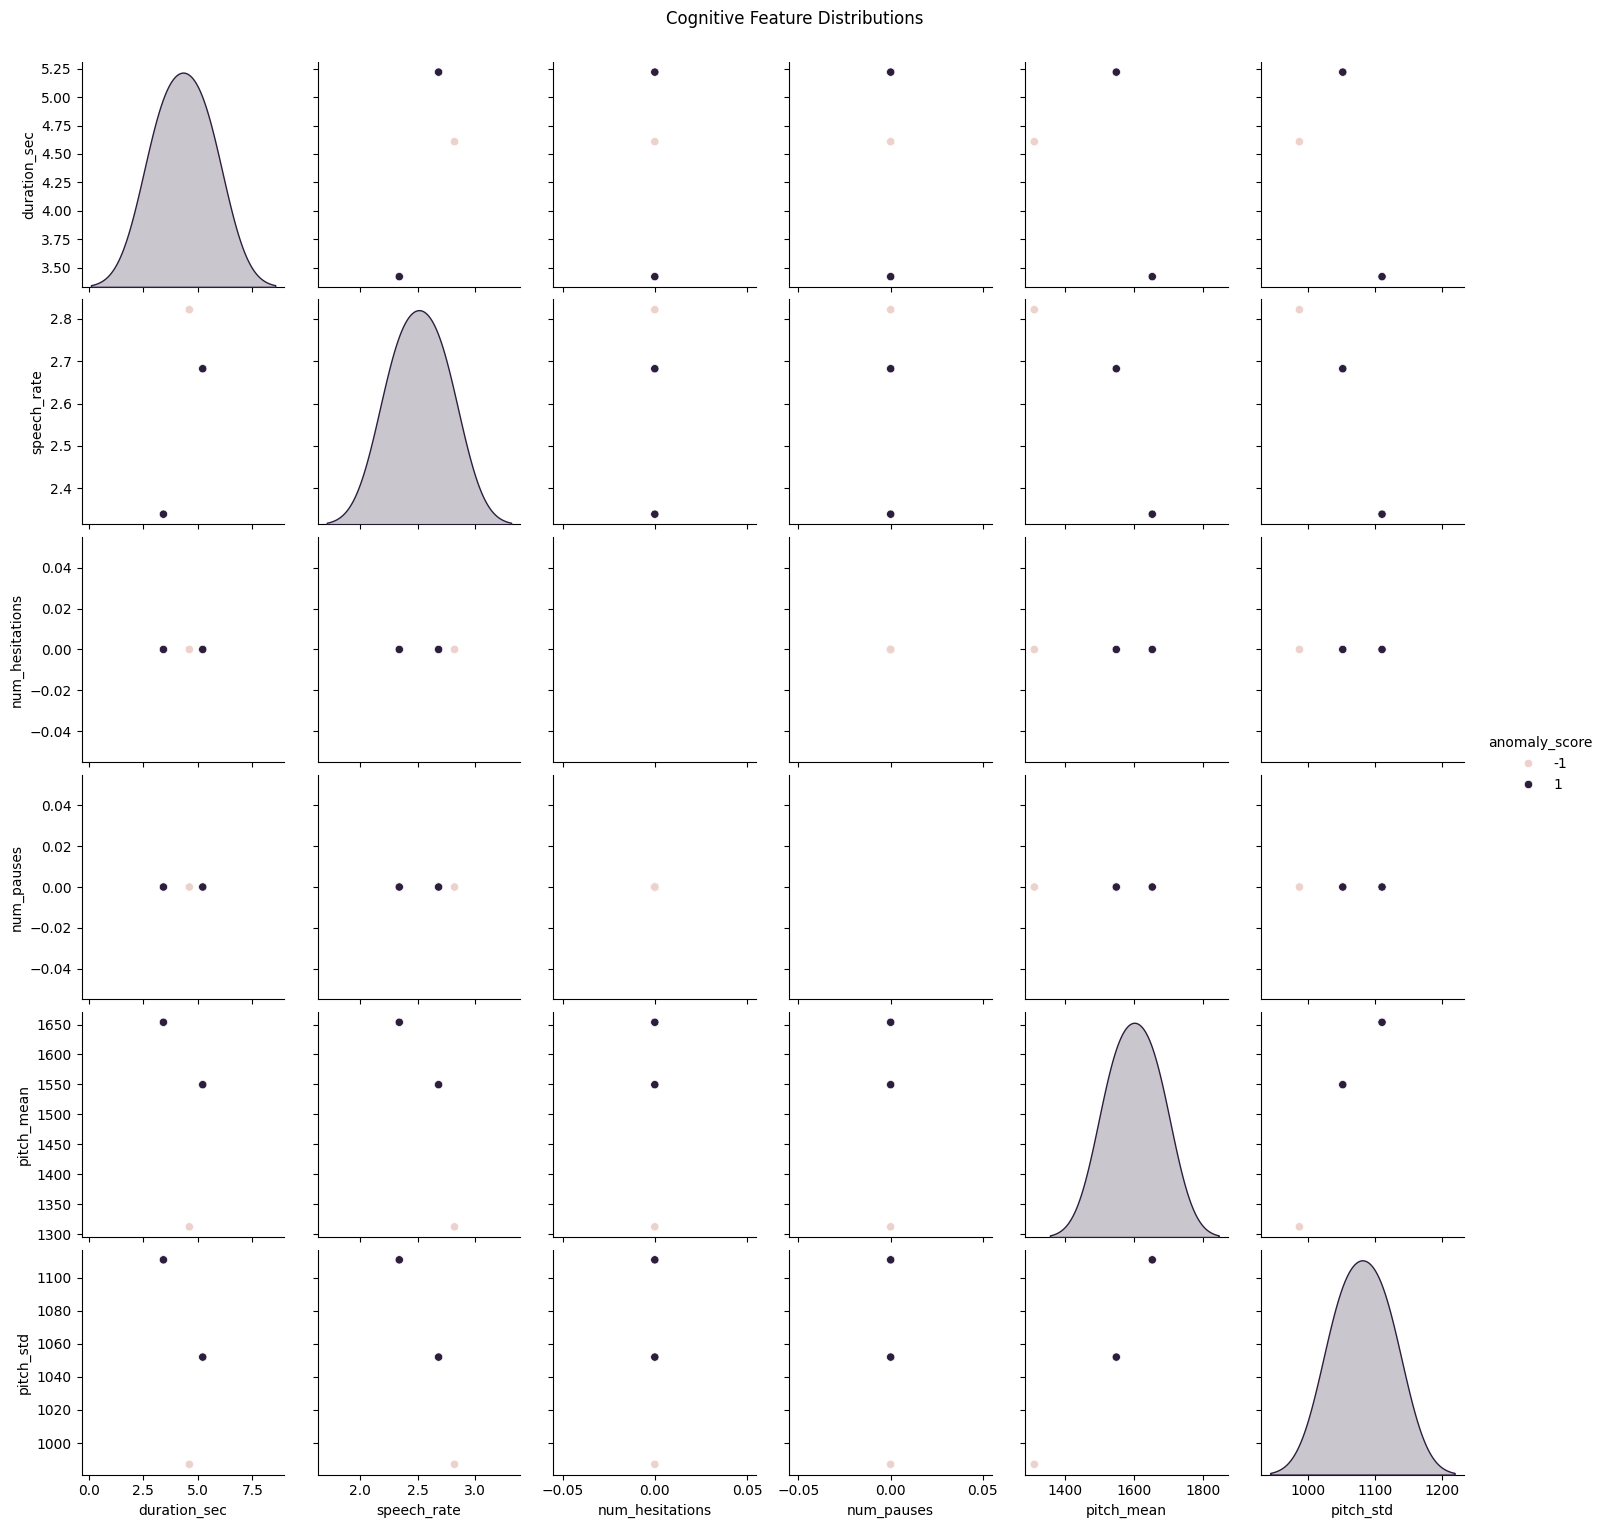

In [25]:
sns.pairplot(df, hue="anomaly_score", diag_kind='kde')
plt.suptitle("Cognitive Feature Distributions", y=1.02)
plt.show()


# ======================
# 💾 EXPORT RESULTS
# ======================
###🚀 PROCESS AUDIO FILES
### ======================

In [26]:

audio_directory = "/content/voice_samples/voice_samples"
feature_data = []

for file in os.listdir(audio_directory):
    if file.endswith(".wav") or file.endswith(".mp3"):
        path = os.path.join(audio_directory, file)
        print(f"Processing {file}...")
        features = extract_features(path)
        feature_data.append(features)

df = pd.DataFrame(feature_data)

Processing sampl1.wav...


<ipython-input-5-3e502baf80a9>:37: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audio_path)
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing sample2.wav...


<ipython-input-5-3e502baf80a9>:37: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audio_path)
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing sample3.wav...


<ipython-input-5-3e502baf80a9>:37: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audio_path)
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


# ======================
# 🤖 ANOMALY DETECTION
# ======================

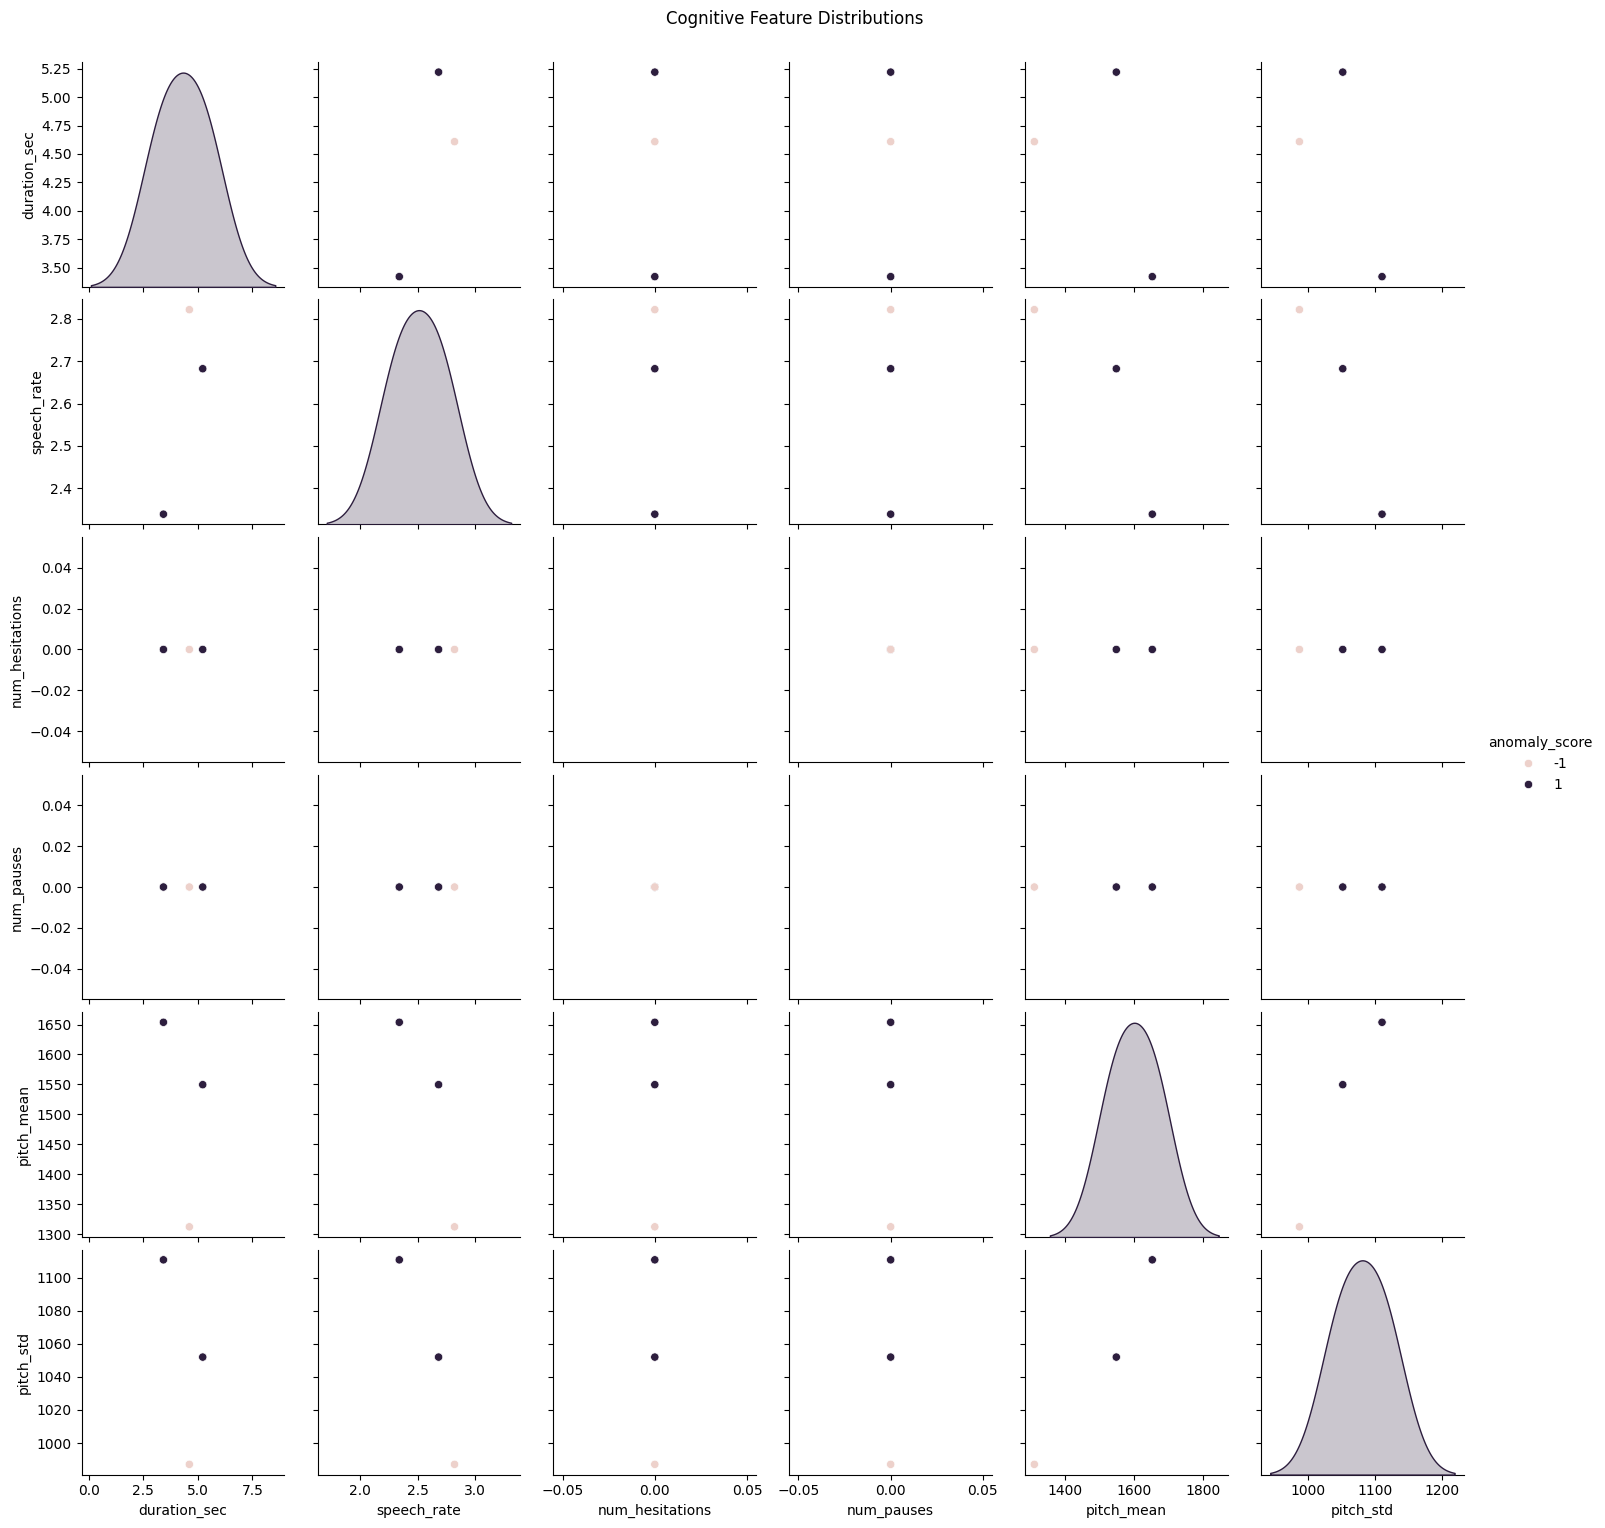

✅ Saved to processed_voice_features.csv


,filename,speech_rate,num_hesitations,num_pauses,pitch_mean,pitch_std,anomaly_score
0,sampl1.wav,2.681992,0,0,1549.545654,1051.954956,1
1,sample2.wav,2.339181,0,0,1653.738647,1110.751587,1
2,sample3.wav,2.821181,0,0,1312.104980,987.099915,-1


In [27]:


feature_cols = ["speech_rate", "num_hesitations", "num_pauses", "pitch_mean", "pitch_std"]
X = df[feature_cols].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = IsolationForest(contamination=0.2, random_state=42)
df['anomaly_score'] = model.fit_predict(X_scaled)

# ======================
# 📊 VISUALIZATION
# ======================
sns.pairplot(df, hue="anomaly_score", diag_kind='kde')
plt.suptitle("Cognitive Feature Distributions", y=1.02)
plt.show()

# ======================
# 💾 EXPORT RESULTS
# ======================
df.to_csv("processed_voice_features.csv", index=False)
print("✅ Saved to processed_voice_features.csv")
df[["filename"] + feature_cols + ["anomaly_score"]]

# ======================
# 📊 HIGHLIGHT ABNORMAL PATTERN
# ======================

In [23]:
at_risk = df[df['anomaly_score'] == -1]
from tabulate import tabulate

at_risk_display = at_risk[['filename', 'speech_rate', 'num_hesitations', 'num_pauses', 'pitch_mean', 'pitch_std']]
print("🧠 Potential Cognitive Impairment Indicators:\n")
print(tabulate(at_risk_display, headers='keys', tablefmt='fancy_grid', showindex=False))



🧠 Potential Cognitive Impairment Indicators:

╒═════════════╤═══════════════╤═══════════════════╤══════════════╤══════════════╤═════════════╕
│ filename    │   speech_rate │   num_hesitations │   num_pauses │   pitch_mean │   pitch_std │
╞═════════════╪═══════════════╪═══════════════════╪══════════════╪══════════════╪═════════════╡
│ sample3.wav │       2.82118 │                 0 │            0 │      1312.11 │       987.1 │
╘═════════════╧═══════════════╧═══════════════════╧══════════════╧══════════════╧═════════════╛
